In [ ]:
from common.config import get_analysis_config

from pandas import DataFrame as pdDataFrame, read_json as pd_read_json

In [4]:
analysis_config = get_analysis_config()
path = analysis_config['output_files']['timers']

eval_df = pd_read_json(path)

for c in eval_df.columns:
    keys = ['training', 'sample']
    c_names = [f'{c} - {e}' for e in keys]
    for e, k in zip(keys, c_names):
        eval_df[k] = eval_df[c].apply(lambda x: x[e] if isinstance(x, dict) else x)
    eval_df[c] = eval_df[c_names].sum(axis=1)
eval_time_df = eval_df
eval_time_df

,sdv.adult,sdv.adult - training,sdv.adult - sample
fabric.regular,234.812302,231.980674,2.831629
sdv.tabular,1.167056,0.725372,0.441684


In [ ]:
from common.config import get_models_config, get_datsets_config

In [5]:
datasets_list = get_datsets_config().keys()
models_list = [k for k,v in get_models_config().items() if v.get('enabled', True)]
eval_df_total = eval_time_df[[c for c in datasets_list if c in eval_time_df.columns]]
eval_df_total

,sdv.adult
fabric.regular,234.812302
sdv.tabular,1.167056


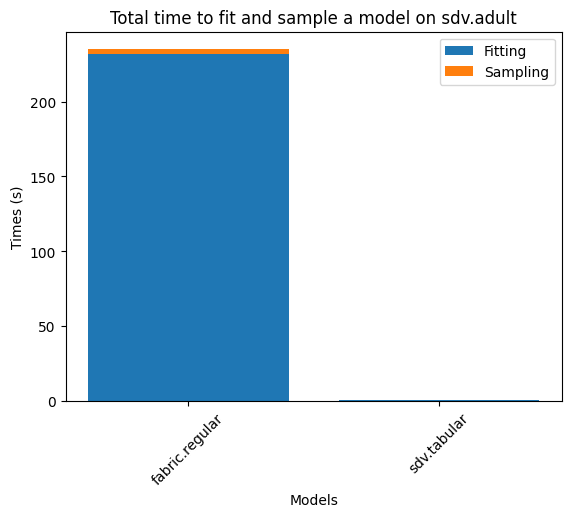

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import base64
from pathlib import Path

from common.config import ANALYSIS_PLOTS_PATH

encoded_imgs = {}

for dataset in datasets_list:
    bars_training = eval_time_df[f'{dataset} - training']
    bars_sampling = eval_time_df[f'{dataset} - sample']
    y_pos = np.arange(len(bars_training))
    
    plt.bar(y_pos, bars_training, label='Fitting')
    plt.bar(y_pos, bars_sampling, bottom=bars_training,  label='Sampling')
        
    plt.xticks(y_pos, models_list)
    plt.xticks(rotation = 45)
    plt.title(f'Total time to fit and sample a model on {dataset}')
    plt.xlabel('Models')
    plt.ylabel('Times (s)')
    plt.legend()
    plt.tight_layout()
    
    p = Path(ANALYSIS_PLOTS_PATH)

    plt.savefig(p / f"time_{dataset}.png")
    tmpfile = BytesIO()
    plt.savefig(tmpfile, format='png')
    encoded_imgs[dataset] = base64.b64encode(tmpfile.getvalue()).decode('utf-8')
    
    plt.show()


In [11]:
import json

metadata = {
    "outputs": [
        {
          "type": "table",
          "storage": "inline",
          "format": "csv",
          "header": [" "] + list(eval_time_df.columns),
          "source": eval_time_df.to_csv()
        }
    ]
  }

for dataset, encoded in encoded_imgs.items():
    metadata['outputs'].append(
        {
          "type": "web-app",
          "storage": "inline",
          "source": f"<img src='data:image/png;base64,{encoded}'>",
        }
    )

with open("mlpipeline-ui-metadata.json", "w") as metadata_file:
    json.dump(metadata, metadata_file)